前回は勾配降下法による学習がどんなものかを紹介しましたが、ごく小規模なモデルしか考慮していませんでした。
今回はもう少し見通しのよいコードを書きましょう。
以下では概ね https://github.com/oreilly-japan/deep-learning-from-scratch のコードを参考にしています。

In [1]:
import numpy as np

## ニューロンの定義

活性化関数(Sigmoid, ReLU)と x・W+b の計算(Affine) を定義しておきます。

In [2]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        y = x.copy()
        y[self.mask] = 0
        return y


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = sigmoid(x)
        return self.out


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        y = np.dot(self.x, self.W) + self.b

        return y


## ネットワークの定義

ネットワークを定義します。

パラメータを表す `params` と、ネットワークの構造を表す `layers` からなります。
特に、 `layers` を層ごとに定義することで、あとでわかるように実装がかなり簡単になります。

![代替テキスト](https://dl.dropboxusercontent.com/s/3m3xhc6j9vfllqu/nn_sample.png)

In [3]:
from collections import OrderedDict

input_size = 2
hidden_size = 2

params = {}
params['W1'] = np.array([[1, -2], [-3, 4]]) #np.random.randn(input_size, hidden_size)
params['b1'] = np.array([1, 2]) #np.random.randn(hidden_size)
params['W2'] = np.array([[2, 3], [4, -5]]) #np.random.randn(input_size, hidden_size)
params['b2'] = np.array([-7, 8]) #np.random.randn(hidden_size)

layers = OrderedDict()
layers['Affine1'] = Affine(params['W1'], params['b1'])
layers['Relu1'] = Relu()
layers['Affine2'] = Affine(params['W2'], params['b2'])

def predict(x):
    for layer in layers.values():
        x = layer.forward(x)
    return x



## 確認

このようなネットワークに入力 1,2 を入力すると 25, -32 が出力され、 -3, -4 を入力すると 13, 38 が出力することがわかります。実際にこの結果が正しいかどうか、手計算でも確認してみてください。

In [4]:
x = np.array([[1,2], [-3,-4]])
y = predict(x)
print(y)

[[ 25 -32]
 [ 13  38]]


## Backpropagation による勾配計算

このままだと前向きの計算しかできないので、Backpropagationを使って勾配を計算できるようにしましょう。

先程の実装に加えて、 `backward` というメソッドを定義します。

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    #
    # Sigmoid ではbackwardの計算のときに「forwardのときの出力」が必要です。
    # このため self.out に forward 時の計算結果を保持しています。
    #
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = sigmoid(x)
        return self.out

    def backward(self, dy):
        dx = dy * (1 - self.out) * self.out
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx


MSEを使ったときのLossも定義しておきましょう。

In [6]:
class LinearWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        self.t = t
        self.y = y
        self.loss = (0.5 * np.sum((y-t) ** 2))  / self.y.shape[0]
        return self.loss

    def backward(self, dout):
        dx = self.y - self.t
        return dx / self.y.shape[0]

さきほどと同じように `params` と `layers` を定義します。
ほとんど同じですが、初期値として正規乱数を使いました。
また、最後にlossを計算するための層を定義しました。

In [7]:
from collections import OrderedDict
np.random.seed(0)

input_size = 2
hidden_size = 2

params = {}
params['W1'] = np.random.randn(input_size, hidden_size)
params['b1'] = np.zeros(hidden_size)
params['W2'] = np.random.randn(input_size, hidden_size)
params['b2'] = np.zeros(hidden_size)

layers = OrderedDict()
layers['Affine1'] = Affine(params['W1'], params['b1'])
layers['Relu1'] = Relu()
layers['Affine2'] = Affine(params['W2'], params['b2'])

lastLayer = LinearWithLoss()

適当な学習データを作りましょう。今回は2入力2出力のニューラルネットワークなので、入力の和と差を計算するようにしてみます。

たとえば、`(0.1, 0.2)` が入力されたら `(0.3, -0.1)` が出力されるようになればうまく学習できていることになります。

In [8]:
x_train = []
y_train = []
for i in range(1000):
    x1 = np.random.rand()
    x2 = np.random.rand()
    y1 = x1 + x2
    y2 = x1 - x2

    x_train.append([x1, x2])
    y_train.append([y1, y2])

x_train = np.array(x_train)
y_train = np.array(y_train)

あると便利な適当な関数をいくつか作ります。

`predict` はネットワークに対して `x` を入力して、 出力 `y` を返す関数です。これまでの実装によって非常に簡潔です。

`loss` はその名の通り loss を計算する関数です。

`gradient` は勾配を計算する関数です。以前は数値微分によって計算していましたが、今回は Backpropagation によって計算しています。

In [9]:
def predict(x):
    for layer in layers.values():
        x = layer.forward(x)
    return x

def loss(x, t):
    y = predict(x)
    return lastLayer.forward(y, t)

In [10]:
def gradient(layers, lastLayer):
    dout = 1
    dout = lastLayer.backward(dout)

    for layer in list(layers.values())[::-1]:
        dout = layer.backward(dout)

    grads = {}
    grads['W1'] = layers['Affine1'].dW
    grads['b1'] = layers['Affine1'].db
    grads['W2'] = layers['Affine2'].dW
    grads['b2'] = layers['Affine2'].db

    return grads

初期化されたまだなにも学習していない状態のニューラルネットワークに (0.1, 0.2) を入力して、出力とlossを表示してみます。

出力は (1.16, -0.44) とまったく異なる結果です。ここから学習をして正しい結果が得られるようになるのかを見ていきましょう。 

In [11]:
x = np.array([[0.1,0.2]])
y = predict(x)
e = loss(x_train, y_train)

print('y')
print(y)

print('e')
print(e)

y
[[ 1.1588448  -0.43758847]]
e
6.264639564364666


## SGD による学習

すでに勾配の計算ができるようになっているので、あとはとても簡単です。

- 勾配を計算する
- パラメータ ← パラメータ - 学習率 * 勾配　としてパラメータを更新

In [12]:
lr = 0.1
n_epochs = 1000
for i in range(n_epochs):
    e = loss(x_train, y_train)
    grad = gradient(layers, lastLayer)

    params['W1'] -= lr * grad['W1']
    params['b1'] -= lr * grad['b1']
    params['W2'] -= lr * grad['W2']
    params['b2'] -= lr * grad['b2']

    #print(i, params['W1'])

    e = loss(x_train, y_train)
    print('loss=', e)

print(params['W1'])
print(params['b1'])
print(params['W2'])
print(params['b2'])

x = np.array([[0.1,0.2]])
y = predict(x)
print(x)
print(y)

loss= 0.2615180997303403
loss= 0.2421363297173496
loss= 0.2299152301860001
loss= 0.22054939444843036
loss= 0.21248881330837593
loss= 0.20517107054889402
loss= 0.19834481104656568
loss= 0.1919589157799367
loss= 0.18591784225039196
loss= 0.18018116912282253
loss= 0.17474625215033796
loss= 0.16954287660624112
loss= 0.16456352449846998
loss= 0.15980725232799017
loss= 0.1552528168870208
loss= 0.1509362478535278
loss= 0.14687667170575702
loss= 0.1430268006657721
loss= 0.13939517800727955
loss= 0.13597178256619372
loss= 0.13273543091503648
loss= 0.1296709105972484
loss= 0.1267778499868967
loss= 0.12404806967773313
loss= 0.12149209874214444
loss= 0.11908498232138003
loss= 0.11681465276401007
loss= 0.11465371710257542
loss= 0.11262331329148959
loss= 0.11071815815587663
loss= 0.10890558227684019
loss= 0.10717039131465915
loss= 0.10551337674606798
loss= 0.10392794505280113
loss= 0.10242813813089802
loss= 0.10100324076877049
loss= 0.09964629253896931
loss= 0.09835676617019191
loss= 0.0971402056642

# MNISTを学習する

より大規模な問題も学習可能かどうか確認しましょう。ここでは手書き文字認識データセットのMNISTを使います。

In [13]:
def load_mnist():
    from sklearn.datasets import fetch_openml
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    return np.array(X), np.array(y)

x_train, y_train = load_mnist()

print(x_train.shape, y_train.shape)


(70000, 784) (70000,)


xが0〜255の値をとるので0〜1に正規化します。

In [14]:
x_train = x_train.astype(np.float) / 255

In [15]:
print(x_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

`y` が one-hot ベクトルではないので one-hot にします。

In [16]:

def to_one_hot(y, n_categories):
    if y.ndim > 1 and y.shape[1] == n_categories:
        return y

    onehot = np.zeros((y.shape[0], n_categories))
    for i, x in enumerate(onehot):
        onehot[i, int(y[i])] = 1
    return onehot

y_train = to_one_hot(y_train, 10)

print(x_train.shape, y_train.shape)


(70000, 784) (70000, 10)


まだ softmax を定義していなかったので、softmax, crossentropy を定義します。

In [17]:
y =np.array([[-1, -2, -3], [-4, -5, -6], [-7, -8, -9]])
t = [1, 0, 2]
y[np.arange(3), t]

array([-2, -4, -9])

In [18]:

def softmax(x):
    # 素朴な実装としては 
    # np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True) になりますが、
    # 入力が大きくなるとオーバーフローするため、
    # 入力から最大値を引くというテクニックを使います
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    t = t.argmax(axis=1)
    batch_size = y.shape[0]
    # y[np.arange(batch_size), t] は 「yのうちtが1になっているものだけを取り出す」処理です
    # たとえば
    #   y =np.array([[-1, -2, -3], [-4, -5, -6], [-7, -8, -9]])
    #   t = [1, 0, 2]
    #   y[np.arange(3), t]
    # は [-2, -4, -9] と表示します。
    # 
    # ただし、この結果が 0 だとゼロ除算になるため、
    # これを回避するために小さい定数を足します
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [19]:
np.random.seed(0)

input_size = 784
hidden_size = 32
output_size = 10

params = {}
params['W1'] = np.random.randn(input_size, hidden_size)
params['b1'] = np.random.randn(hidden_size)
params['W2'] = np.random.randn(hidden_size, hidden_size)
params['b2'] = np.random.randn(hidden_size)
params['W3'] = np.random.randn(hidden_size, output_size)
params['b3'] = np.random.randn(output_size)

layers = OrderedDict()
layers['Affine1'] = Affine(params['W1'], params['b1'])
layers['Relu1'] = Relu()
layers['Affine2'] = Affine(params['W2'], params['b2'])
layers['Relu2'] = Relu()
layers['Affine3'] = Affine(params['W3'], params['b3'])

lastLayer = SoftmaxWithLoss()

In [20]:
def gradient(layers, lastLayer):
    dout = 1
    dout = lastLayer.backward(dout)

    for layer in list(layers.values())[::-1]:
        dout = layer.backward(dout)

    grads = {}
    grads['W1'] = layers['Affine1'].dW
    grads['b1'] = layers['Affine1'].db
    grads['W2'] = layers['Affine2'].dW
    grads['b2'] = layers['Affine2'].db
    grads['W3'] = layers['Affine3'].dW
    grads['b3'] = layers['Affine3'].db

    return grads

In [21]:

lr = 0.01
n_epochs = 10000
batch_size = 128

for i in range(n_epochs):
    batch_indexes = np.random.choice(x_train.shape[0], batch_size, replace=False)

    batch_x = x_train[batch_indexes]
    batch_y = y_train[batch_indexes]
    
    e = loss(batch_x, batch_y)
    grad = gradient(layers, lastLayer)

    params['W1'] -= lr * grad['W1']
    params['b1'] -= lr * grad['b1']
    params['W2'] -= lr * grad['W2']
    params['b2'] -= lr * grad['b2']
    params['W3'] -= lr * grad['W3']
    params['b3'] -= lr * grad['b3']

    #print(i, params['W1'])

    if i % batch_size == 0:
        print('loss=', e)


loss= 15.020504960995275
loss= 5.578668624901248
loss= 4.378053236071812
loss= 3.6090995676534434
loss= 2.079817802810772
loss= 1.7479190010645276
loss= 1.7352224820739521
loss= 1.7730512191609598
loss= 1.201597949684475
loss= 1.422297189070687
loss= 1.2607803559639277
loss= 1.2904797304525912
loss= 1.1764473123204668
loss= 1.431975066691565
loss= 1.4544219356467178
loss= 1.0179497200916376
loss= 1.2283123827937872
loss= 1.2007202623937303
loss= 1.2346118500187413
loss= 1.0818169455702447
loss= 1.1064078099353292
loss= 1.0045487181460082
loss= 0.9678286585835492
loss= 1.274069040253778
loss= 1.2897279917217823
loss= 0.9180152258859475
loss= 1.05965151553072
loss= 0.950134950246655
loss= 1.1191918450790892
loss= 0.8851342179970261
loss= 0.6596525991156189
loss= 1.0740833845693305
loss= 0.8770699223205045
loss= 0.7069342628134303
loss= 0.8984189563996722
loss= 0.851245888897949
loss= 0.926321378569957
loss= 0.8280299461195418
loss= 0.9514537214214446
loss= 1.0217478965814855
loss= 0.8309

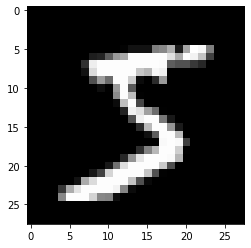

5


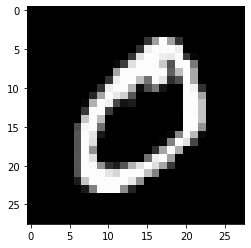

0


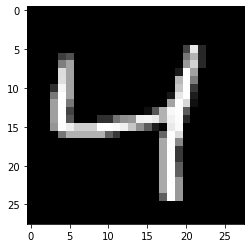

4


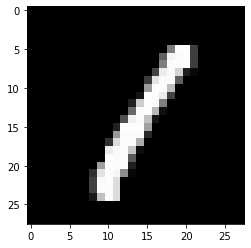

1


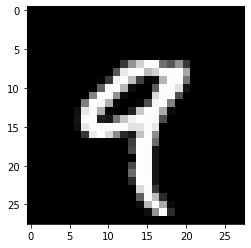

9


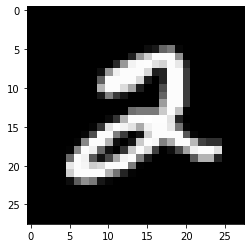

2


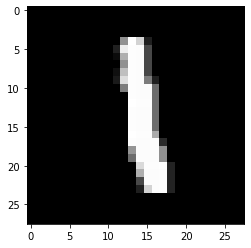

1


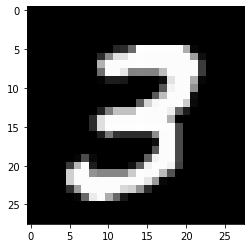

3


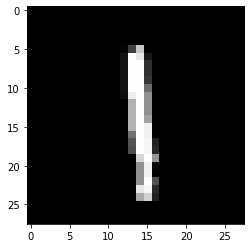

1


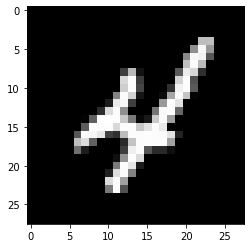

4


In [22]:
import matplotlib.pyplot as plt
def show_mnist(x):
    x = x.reshape(28, 28)
    plt.imshow(x)
    plt.gray()
    plt.show()

for index in range(10):
    show_mnist(x_train[index])
    output = predict(np.array([x_train[index]]))[0]
    print(np.argmax(output))

これまでに見てきたように、どんなに複雑なネットワークでも、各層ごとに forward と backward を正確に定義すれば、Backpropagationを使って勾配を簡単に求めることができます。
勾配の計算は各層ごとに閉じており、局所的な計算だけで全体の勾配を求めることができるためとても便利です。